In [219]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set_palette('Set2')
sns.set_style('whitegrid')

import matplotlib.pyplot as plt
%matplotlib inline

import requests
import json
import datetime
import time

from sklearn.preprocessing import KBinsDiscretizer

In [220]:
target = 'inside_sales'

In [221]:
file = 'csv/CSV_for_EDA_NEW.csv'

In [222]:
df = pd.read_csv(file, index_col='date', parse_dates=True)

In [223]:
def clean_up_for_eda(df):
    
    #df['outside'] = df['outside'].replace({0: 'outside_closed',
                              #1: 'outside_open'})

    df['day_of_week'] = df.index.dayofweek
    
    df['day_of_week'] = df['day_of_week'].replace({0: 'Mon', 
                       1: 'Tue',
                       2: 'Wed',
                       3: 'Thu',
                       4: 'Fri',
                       5: 'Sat',
                       6: 'Sun'})

    df['year'] = df.index.year
    
    # Drop Closed Nights for EDA
    df = df[df.inside_sales > 500]
    
    temp_enc = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')
    x = temp_enc.fit_transform(df[['apparent_temperature']])
    
    temp = pd.DataFrame(x, index=df.index)
    
    temp = temp.replace({0: 'very_cold',
                    1: 'cold',
                    2: 'warm',
                    3: 'hot'})
    
    df = df.merge(temp, on='date', how='left')
    
    df = df.rename(columns={0: 'temperature_bin'})
    
    df.loc['2019-05-25', 'inside_covers'] = np.mean(df.inside_covers)
    df.loc['2018-10-04', 'inside_covers'] = np.mean(df.inside_covers)
    df.loc['2019-01-26', 'inside_covers'] = np.mean(df.inside_covers)
    
    df['inside_ppa'] = df['inside_sales'] / df['inside_covers']
    
    return df

df = clean_up_for_eda(df)

In [224]:
df.describe()

,inside_sales,outside_sales,inside_covers,outside_covers,reserved_covers,walkin_covers,waitlist_covers,no_show_covers,no_show_parties,apparent_temperature,humidity,precip_intensity_max,precip_prob,pressure,temperature,year,inside_ppa
count,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000
mean,14575.626020,2049.896812,183.477784,33.659978,131.192865,26.826087,58.658863,9.868450,3.793757,55.257480,0.631126,0.028356,0.080256,1016.785786,56.205641,2017.799331,79.601584
std,1832.179145,2528.046093,16.832798,41.349708,14.879937,24.989169,28.205670,7.244339,2.735523,20.250873,0.186380,0.064966,0.227491,7.948590,17.969704,0.748421,8.648230
min,10713.180000,0.000000,125.000000,0.000000,22.000000,0.000000,0.000000,0.000000,0.000000,-5.390000,0.140000,0.000000,0.000000,989.220000,9.160000,2017.000000,57.909081
25%,13317.170000,0.000000,171.000000,0.000000,122.000000,3.000000,38.000000,4.000000,2.000000,39.230000,0.490000,0.000000,0.000000,1011.780000,41.060000,2017.000000,74.245250
50%,14304.030000,0.000000,183.000000,0.000000,131.000000,20.000000,51.000000,8.000000,3.000000,55.960000,0.620000,0.000700,0.000000,1016.590000,55.960000,2018.000000,78.382434
75%,15589.400000,4611.000000,194.000000,74.000000,140.000000,46.000000,73.000000,14.000000,5.000000,72.920000,0.780000,0.021000,0.000000,1021.650000,72.620000,2018.000000,83.249953
max,27909.750000,8129.500000,246.000000,137.000000,197.000000,134.000000,150.000000,40.000000,14.000000,96.240000,0.970000,0.668000,1.000000,1039.820000,90.570000,2019.000000,166.129464


In [225]:
df.groupby('precip_type')[target].aggregate(['mean', 'count'])

,mean,count
precip_type,,
none,14421.572500,452
rain,14719.697324,411
sleet,17417.110000,1
snow,14805.244242,33


In [226]:
df[['inside_sales', 'inside_covers', 'inside_ppa']].resample('Y').agg(['mean', 'std'])

inside_sales              inside_covers            inside_ppa  \
                    mean          std          mean        std       mean   
date                                                                        
2017-12-31  14604.728579  1693.370460    187.576602  17.587105  78.054717   
2018-12-31  14319.761421  1703.117125    179.281887  16.210391  80.013961   
2019-12-31  15030.416927  2225.933625    183.672485  14.361148  81.876901   

                       
                  std  
date                   
2017-12-31   7.857562  
2018-12-31   7.830689  
2019-12-31  10.890397

In [227]:
# df.groupby('outside')[['sales', 'covers', 'ppa']].mean()

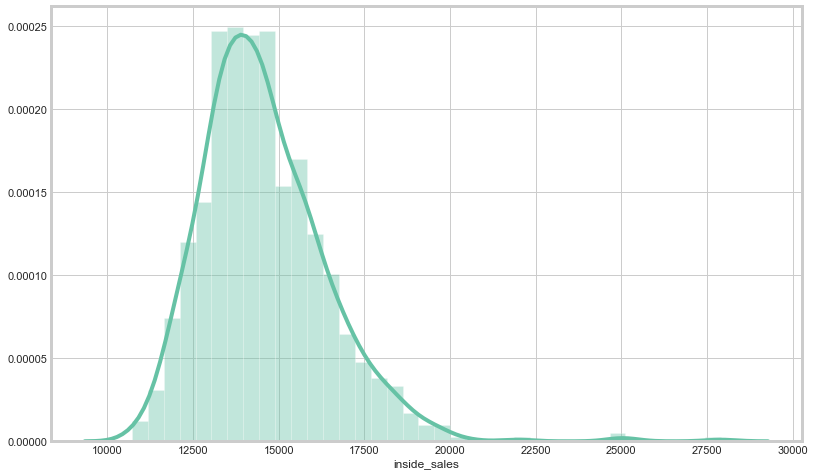

In [228]:
# Histogram of Sales
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
sns.distplot(df[target]);

In [229]:
df.head()

,inside_sales,outside_sales,inside_covers,outside_covers,reserved_covers,walkin_covers,waitlist_covers,no_show_covers,no_show_parties,apparent_temperature,...,precip_max_time,precip_prob,precip_type,pressure,summary,temperature,day_of_week,year,temperature_bin,inside_ppa
date,,,,,,,,,,,,,,,,,,,,,
2017-01-02,13159.84,0.0,174.0,0,106,26,42,17,6,35.58,...,15:00:00,0.79,rain,1027.98,rain,39.06,Mon,2017,cold,75.631264
2017-01-03,12442.11,0.0,181.0,0,119,31,31,14,4,41.50,...,17:00:00,0.77,rain,1000.08,rain,43.19,Tue,2017,cold,68.740939
2017-01-04,12927.64,0.0,174.0,0,131,17,26,5,2,36.81,...,00:00:00,0.00,rain,1002.55,clear-night,42.29,Wed,2017,cold,74.296782
2017-01-05,14457.79,0.0,191.0,0,138,25,28,4,2,27.11,...,05:01:00,0.00,none,1014.61,cloudy,31.36,Thu,2017,very_cold,75.695236
2017-01-06,15331.97,0.0,200.0,0,130,16,54,6,3,24.74,...,12:00:00,0.00,snow,1022.80,partly-cloudy-night,29.42,Fri,2017,very_cold,76.659850


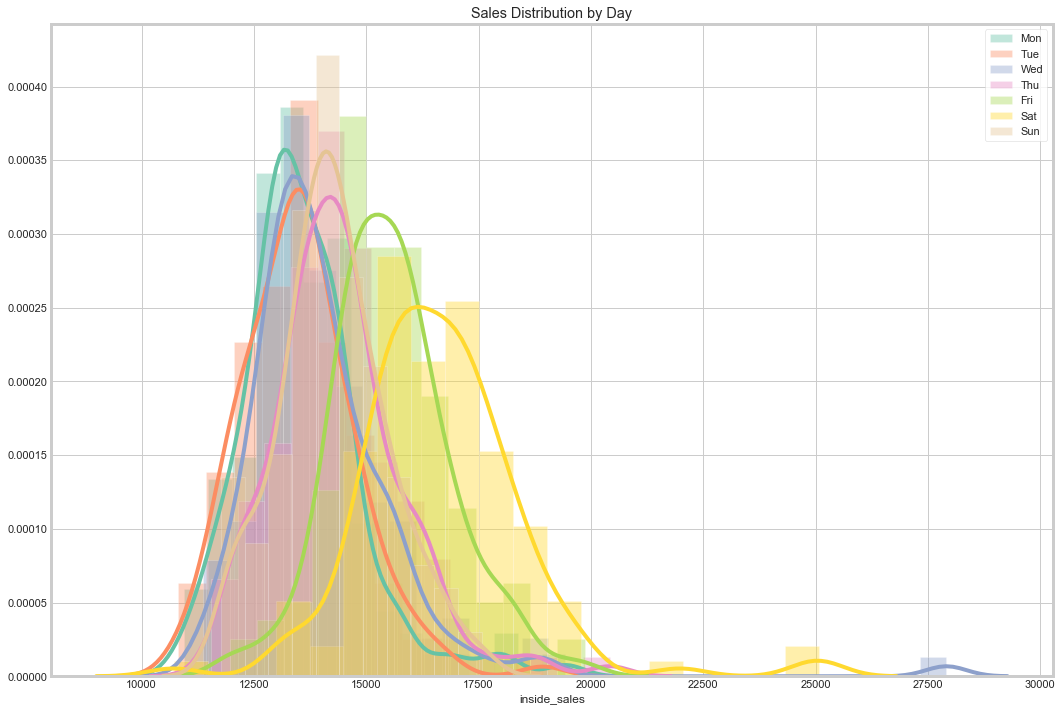

In [230]:
# Histogram of Sales by Day
sns.set_style('whitegrid')
sns.set_palette('Set2')
plt.figure(figsize=(16,12))
sns.distplot( df[df['day_of_week'] == 'Mon'][target], label="Mon")
sns.distplot( df[df['day_of_week'] == 'Tue'][target],label="Tue")
sns.distplot( df[df['day_of_week'] == 'Wed'][target], label="Wed")
sns.distplot( df[df['day_of_week'] == 'Thu'][target], label="Thu")
sns.distplot( df[df['day_of_week'] == 'Fri'][target], label="Fri")
sns.distplot( df[df['day_of_week'] == 'Sat'][target], label="Sat")
sns.distplot( df[df['day_of_week'] == 'Sun'][target], label="Sun")
plt.legend()
plt.title('Sales Distribution by Day')
plt.show();


In [231]:
df['2018'][target].describe()

count      359.000000
mean     14319.761421
std       1703.117125
min      10950.130000
25%      13149.110000
50%      14071.110000
75%      15337.485000
max      21976.760000
Name: inside_sales, dtype: float64

In [232]:
def corr_map(df):
    
    corr = df.corr()

    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    sns.set_style('whitegrid')
    f, ax = plt.subplots(figsize=(16, 12))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.75, annot=False, cbar_kws={"shrink": .75});
    
def corr_plots(df):
    
    y = target
    
    sns.set(style='whitegrid', palette='deep')

    for col in [col for col in df.columns if col != target]:
        
        try:
            sns.regplot(x=col, y=y, data=df)
            plt.title(f'Correlation between {col} and {target}: {df[y].corr(df[col]):.2f}')
            plt.show();
            
        except:
            pass

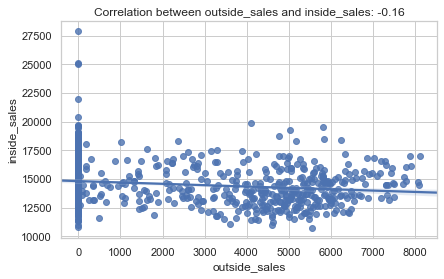

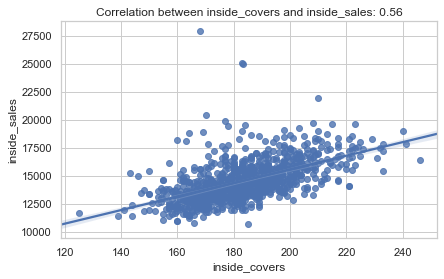

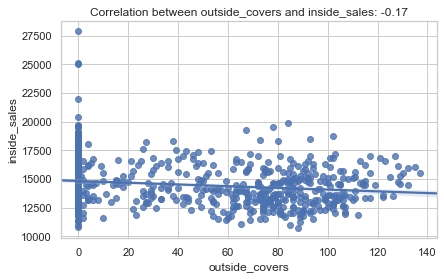

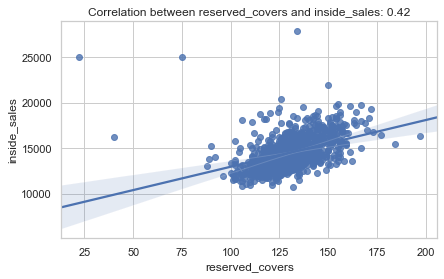

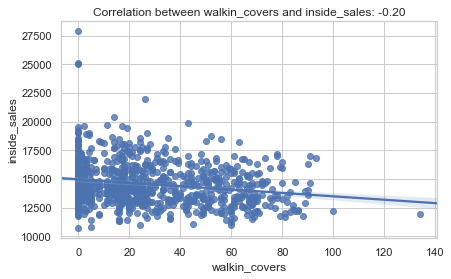

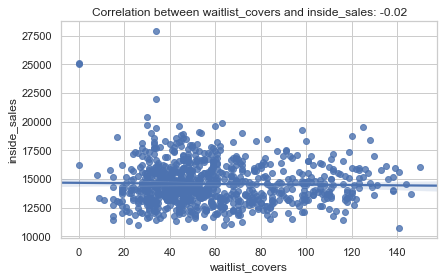

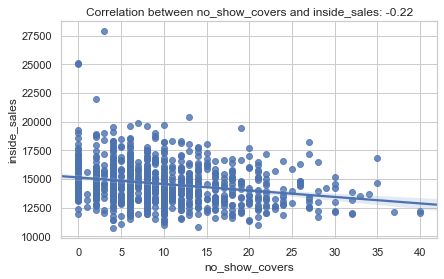

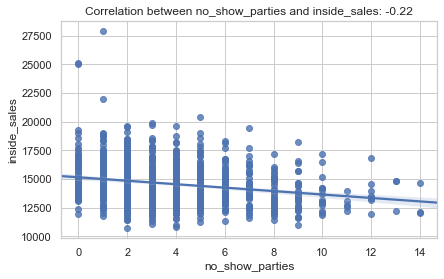

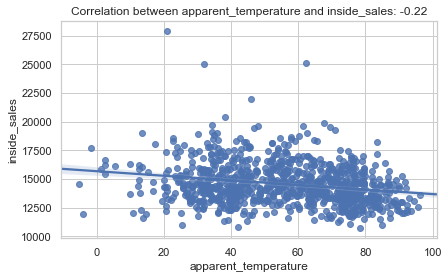

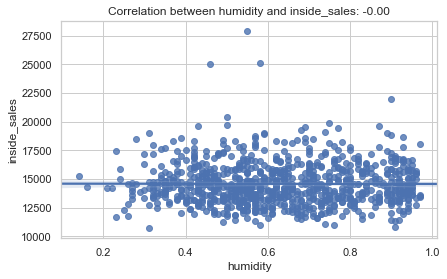

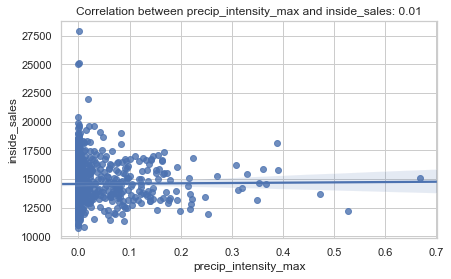

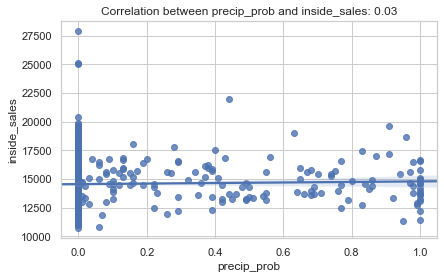

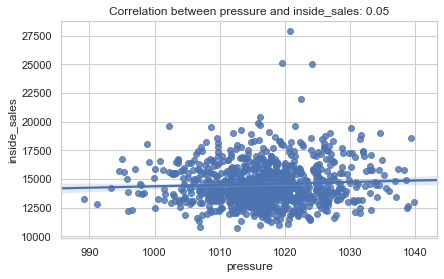

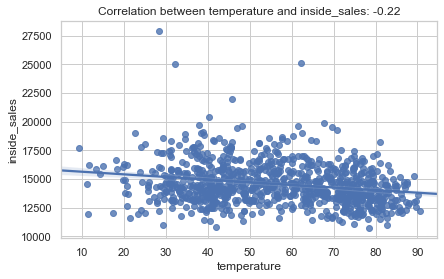

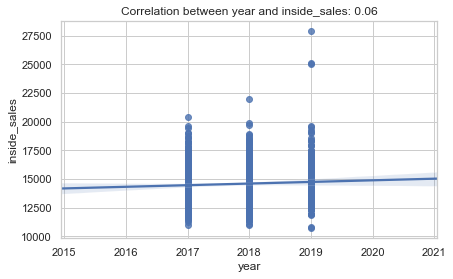

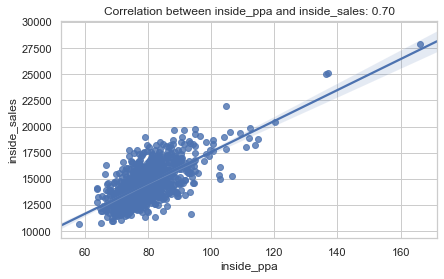

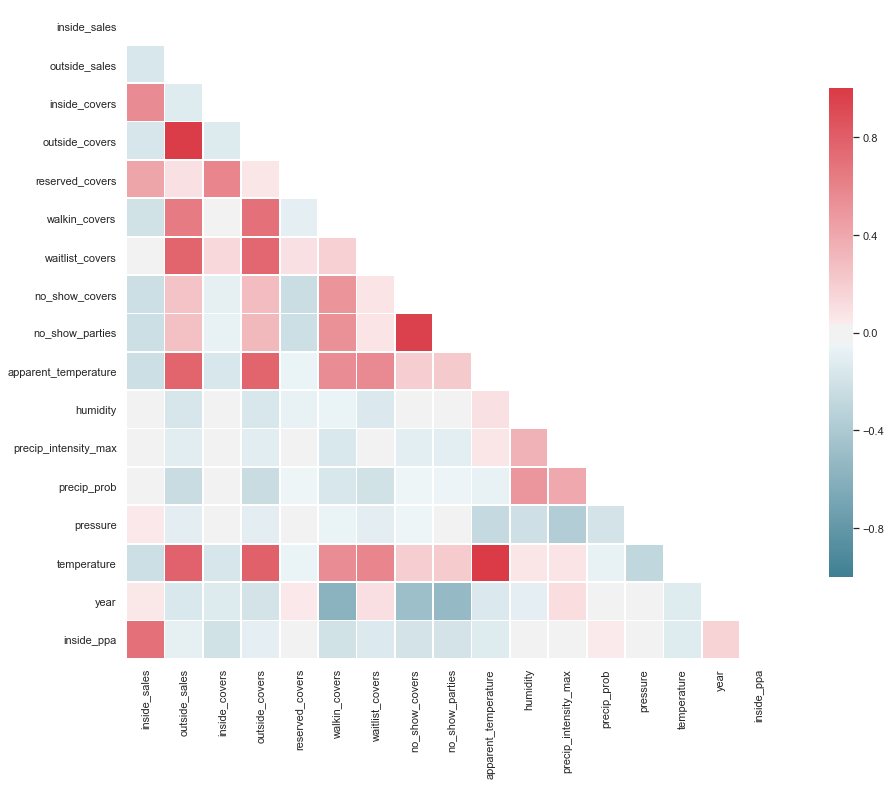

In [233]:
def pre_engineering_eda(df):

    corr_plots(df)
    corr_map(df)

    return df

df = pre_engineering_eda(df)

In [234]:
df_ytd = df[df.index.month < 6] # Analyzing Months 1 through 5
dfm_total = df.resample('M').sum()
dfm_avg = df.resample('M').mean()

In [235]:
x = pd.melt(df[[target, 'inside_covers']].resample('M').mean().reset_index(), id_vars='date')

In [236]:
df.groupby(['day_of_week', 'year'])[target, 'inside_covers', 'inside_ppa'].mean()

inside_sales  inside_covers  inside_ppa
day_of_week year                                         
Fri         2017  15665.206154     194.096154   80.959468
            2018  15192.006731     182.173077   83.498587
            2019  16076.673846     188.769231   85.168922
Mon         2017  13449.396667     178.098039   75.610833
            2018  13558.734510     173.607843   78.097860
            2019  13838.373200     179.000000   77.362808
Sat         2017  16531.465192     210.615385   78.645944
            2018  16231.699038     197.750000   82.229233
            2019  17810.822692     199.975955   89.490760
Sun         2017  14351.188200     197.680000   72.667317
            2018  14026.630588     189.745098   74.108752
            2019  14580.816800     193.040000   75.567530
Thu         2017  14513.262941     181.078431   80.252612
            2018  14192.855882     171.905830   82.779685
            2019  14485.094231     179.076923   80.917109
Tue         2017  13516.300784     174.039216   78.105320
            2018  13278.227451     168.647059   78.893969
            2019  13932.678400     171.840000   81.232146
Wed         2017  14151.620385     177.250000   79.930557
            2018  13703.583922     170.725490   80.377879
            2019  14383.098462     173.730769   82.957948

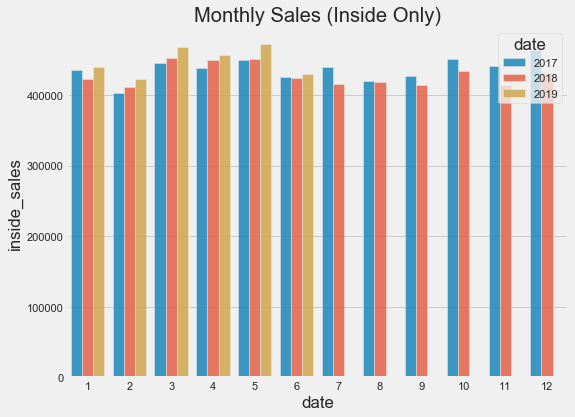

In [237]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8,6))

sns.barplot(x=dfm_total.index.month, y=target, hue=dfm_total.index.year, data=dfm_total, alpha=0.85, ci=False)
plt.title('Monthly Sales (Inside Only)');

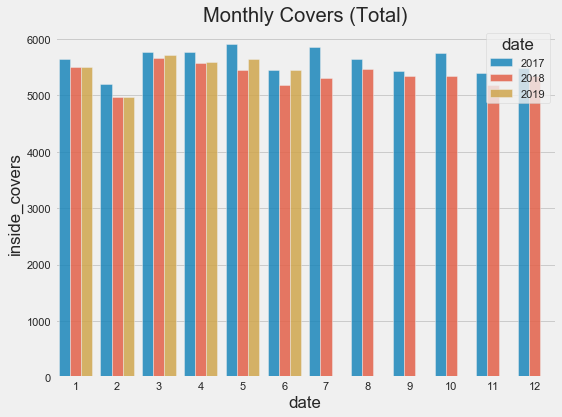

In [238]:
plt.figure(figsize=(8,6))
sns.barplot(x=dfm_total.index.month, y='inside_covers', hue=dfm_total.index.year, data=dfm_total, alpha=0.85, ci=False)
plt.title('Monthly Covers (Total)');

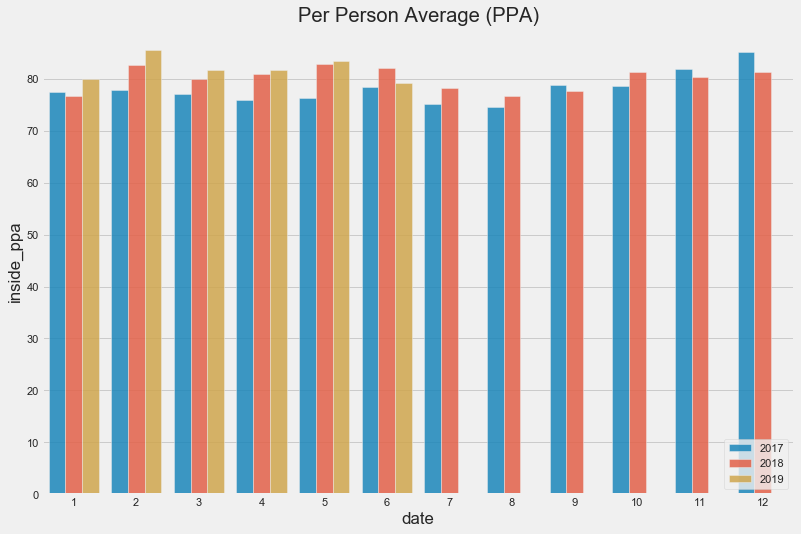

In [239]:
plt.figure(figsize=(12,8))
sns.barplot(x=dfm_avg.index.month, y='inside_ppa', hue=dfm_avg.index.year, data=dfm_avg, alpha=0.85, ci=False)
plt.legend(loc='lower right')
plt.title('Per Person Average (PPA)');

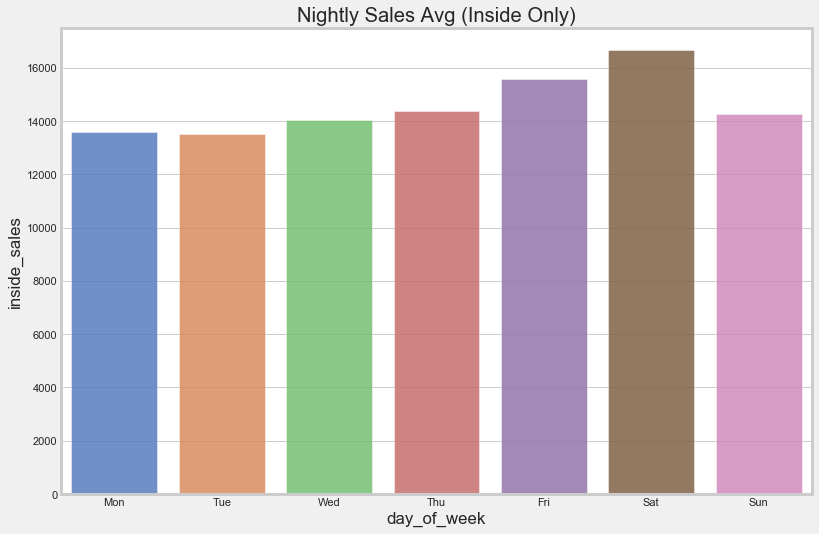

In [240]:
plt.figure(figsize=(12,8))
sns.set_style('whitegrid')
sns.set_palette('muted')
sns.barplot(x='day_of_week', y=target, data=df, alpha=0.85, ci=False)
plt.title('Nightly Sales Avg (Inside Only)');

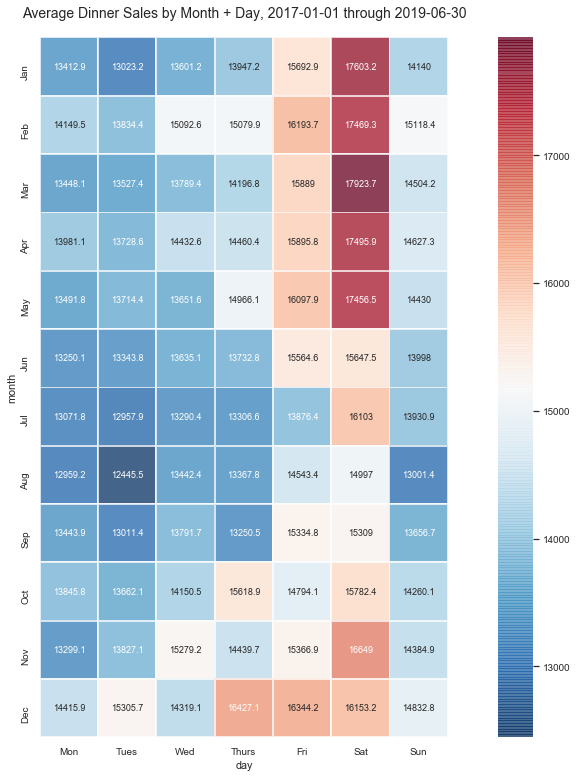

In [241]:
def sales_heatmap(df, start_date, end_date):
    
    sns.set_style('whitegrid')
    temp_df = df[(df.index > start_date) & (df.index < end_date)]
    
    matrix = temp_df.groupby([temp_df.index.month, temp_df.index.dayofweek]).agg({target: 'mean'})
    matrix = matrix.rename_axis(['month', 'day'])
    temp_df = matrix.unstack(level=1)

    plt.figure(figsize=(16,12))
    sns.set(font_scale=0.9)
    sns.set_style('whitegrid')
    sns.heatmap(temp_df, square=True, linewidths=0.75, annot=True, annot_kws={"size": 9}, fmt='g', 
                cmap='RdBu_r', alpha=0.75, yticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                xticklabels=['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
    plt.ylabel('month')
    plt.xlabel('day')
    plt.title(f'Average Dinner Sales by Month + Day, {start_date} through {end_date}',size=14, pad=20)
    plt.show();
    
sales_heatmap(df, '2017-01-01', '2019-06-30')

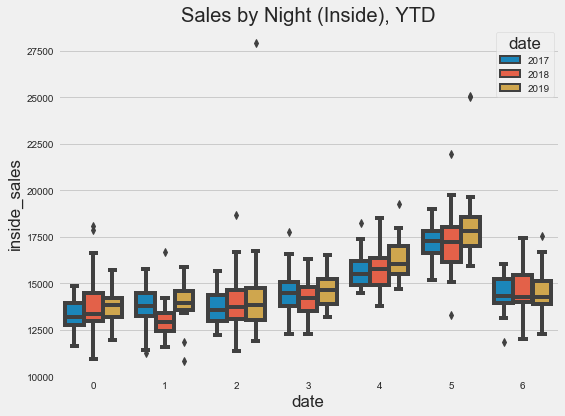

In [242]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8,6))
sns.boxplot(x=df_ytd.index.dayofweek,
               y=target,
               hue=df_ytd.index.year,
               data=df_ytd
                );

plt.title('Sales by Night (Inside), YTD');

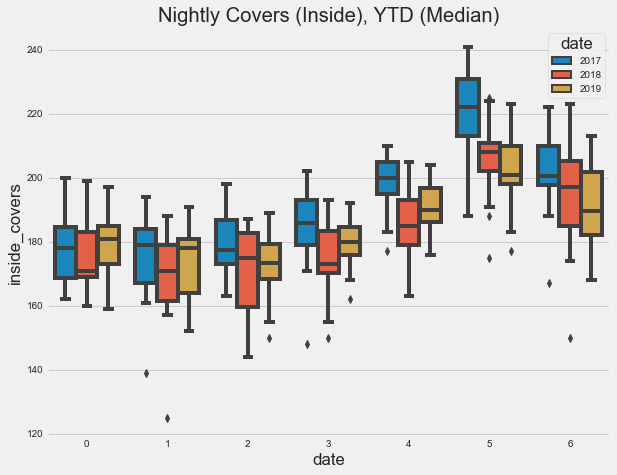

In [243]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(9,7))
sns.boxplot(x=df_ytd.index.dayofweek,
               y='inside_covers',
               hue=df_ytd.index.year,
               data=df_ytd
                );

plt.title('Nightly Covers (Inside), YTD (Median)');

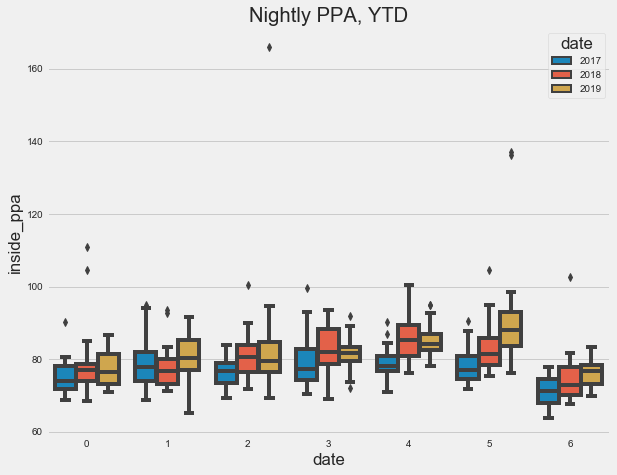

In [244]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(9,7))
sns.boxplot(x=df_ytd.index.dayofweek,
               y='inside_ppa',
               hue=df_ytd.index.year,
               data=df_ytd
                );

plt.title('Nightly PPA, YTD');

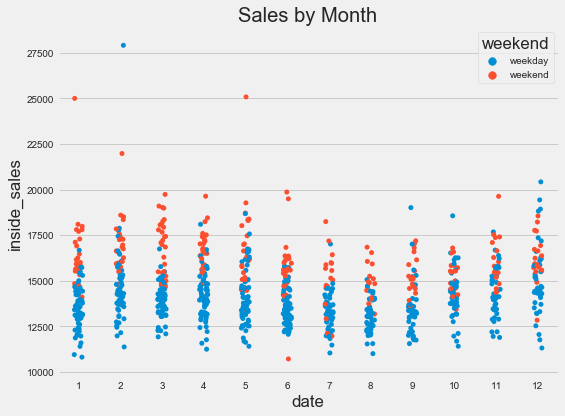

In [252]:
df['weekend'] = np.where((df['day_of_week'] == 'Fri') | (df['day_of_week'] == 'Sat'), 'weekend', 'weekday')

plt.style.use('fivethirtyeight')
plt.figure(figsize=(8,6))
sns.stripplot(x=df.index.month,
               y='inside_sales',
               hue='weekend',
               data=df
                );

plt.title('Sales by Month');

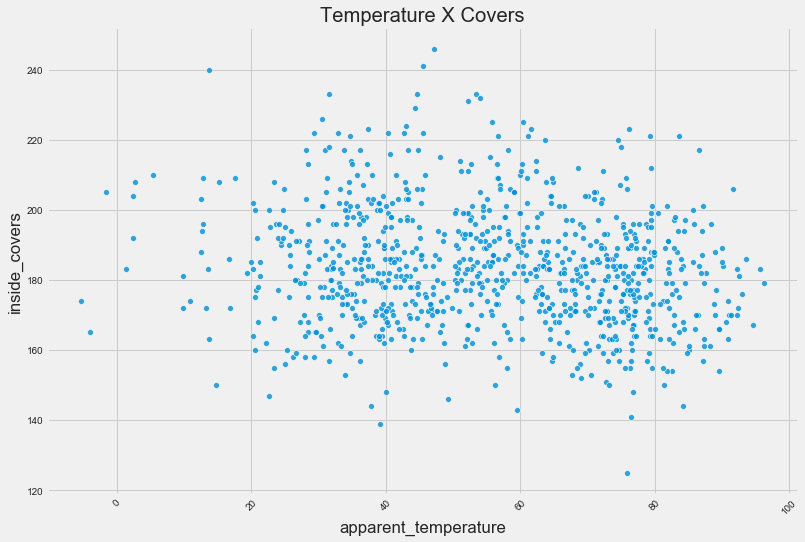

In [255]:
def scatter_plot(col_1, col_2, col_hue, data):
    
    plt.figure(figsize=(12,8))
    sns.scatterplot(x=col_2, y=col_1, hue=col_hue, data=data, alpha=.8)
    plt.xticks(rotation=45)
    plt.title('Temperature X Covers');
    plt.show();
    
scatter_plot('inside_covers', 'apparent_temperature', None, df)

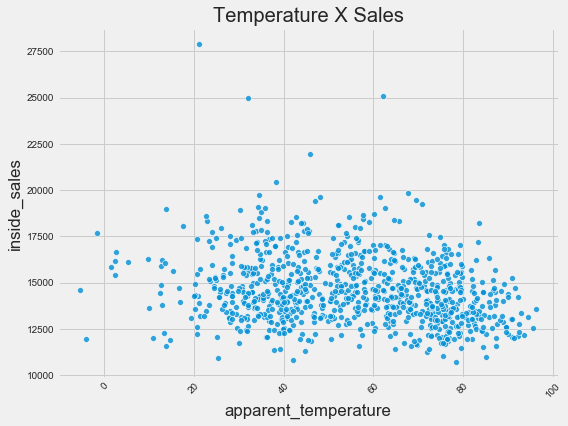

In [258]:
def scatter_plot(col_1, col_2, col_hue, data):
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=col_2, y=col_1, hue=col_hue, data=data, alpha=.8)
    plt.xticks(rotation=45)
    plt.title('Temperature X Sales');
    plt.show();
    
scatter_plot('inside_sales', 'apparent_temperature', None, df)

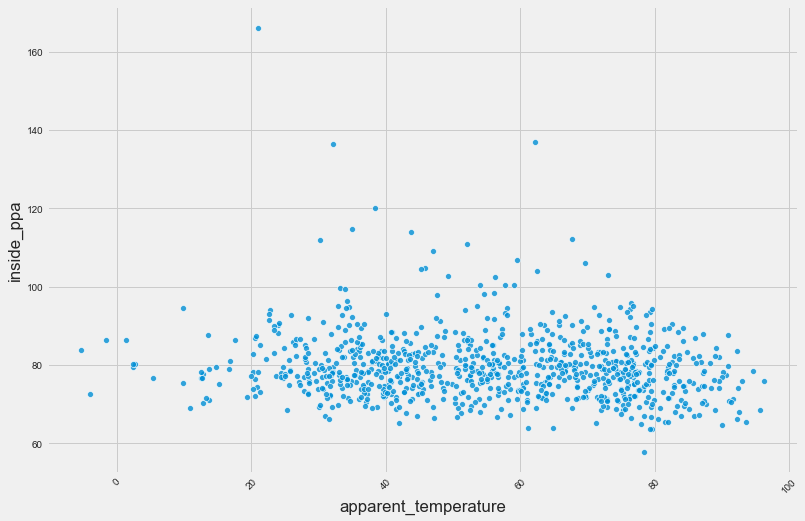

In [260]:
def scatter_plot(col_1, col_2, col_hue, data):
    
    plt.figure(figsize=(12,8))
    sns.scatterplot(x=col_2, y=col_1, hue=col_hue, data=data, alpha=.8)
    plt.xticks(rotation=45)
    plt.show();
    
scatter_plot('inside_ppa', 'apparent_temperature', None, df)

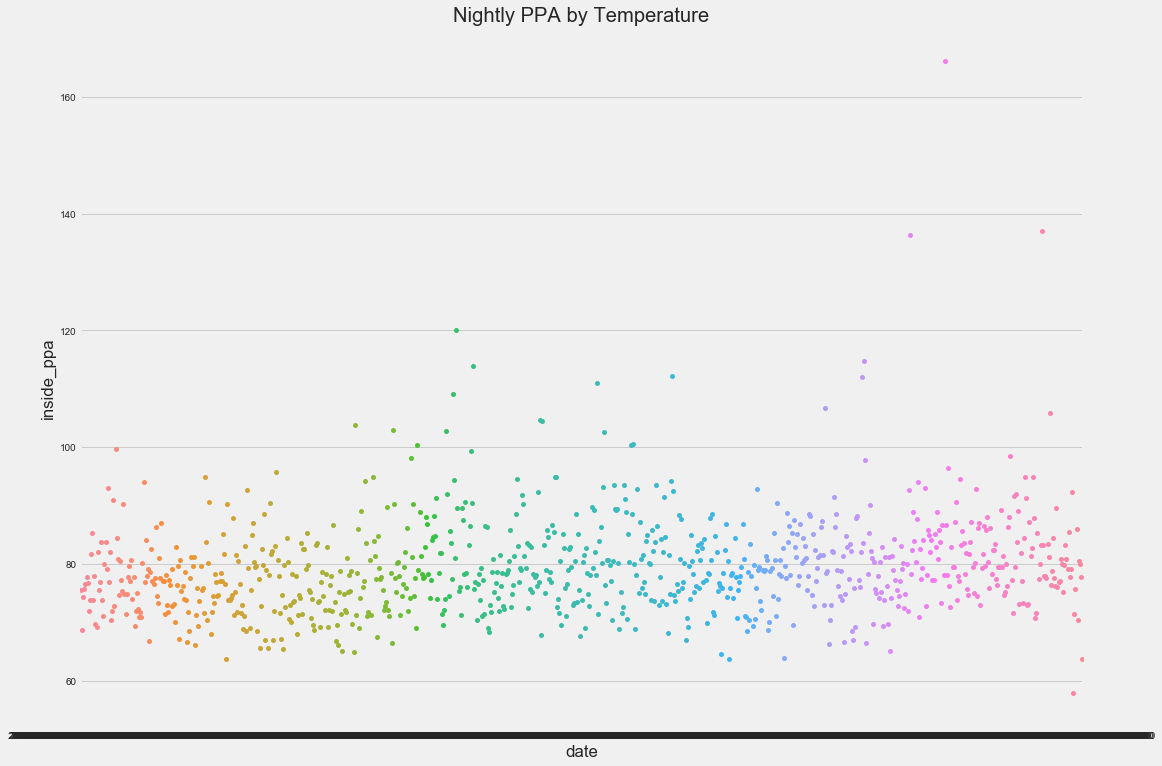

In [262]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,12))

sns.stripplot(x=df.index,
               y='inside_ppa',
               hue=None,
               data=df
                )

plt.title('Nightly PPA by Temperature');

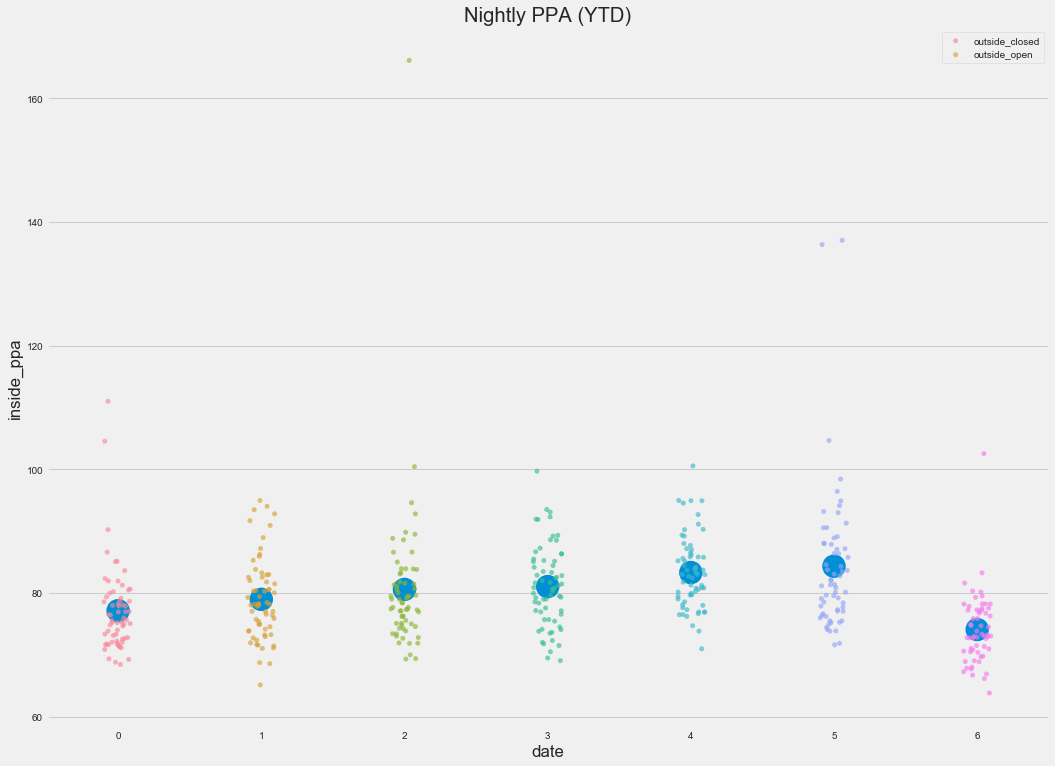

In [263]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,12))
sns.stripplot(x=df_ytd.index.dayofweek,
               y='inside_ppa',
               hue=None,
               data=df_ytd,
               dodge=0.35,
               alpha=0.65
                );

sns.pointplot(x=df_ytd.index.dayofweek,
               y='inside_ppa',
               hue=None,
               data=df_ytd,
               dodge=0.55,
               alpha=0.75,
               join=False,
               ci=None
                );


plt.legend(['outside_closed', 'outside_open'])
plt.title('Nightly PPA (YTD)');

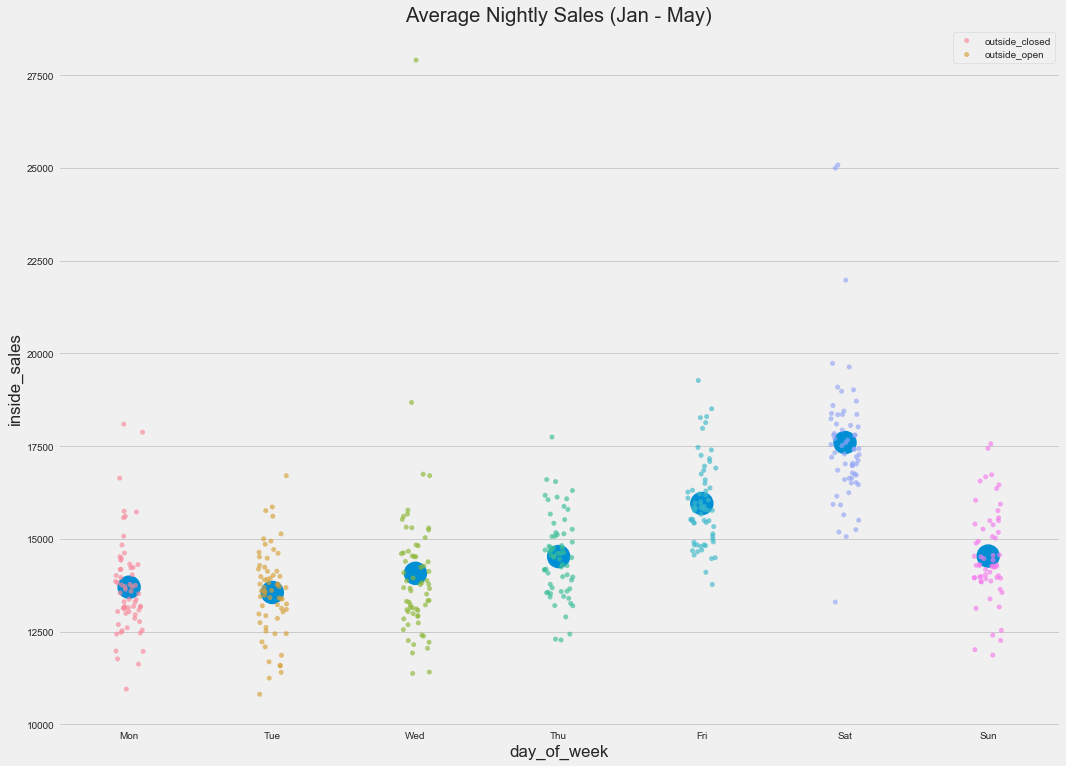

In [264]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,12))
sns.stripplot(x='day_of_week',
               y=target,
               hue=None,
               data=df_ytd,
               dodge=0.05,
               alpha=0.65
                );

sns.pointplot(x='day_of_week',
               y=target,
               hue=None,
               data=df_ytd,
               dodge=0.40,
               alpha=0.75,
               join=False,
               ci=None
                );


plt.legend(['outside_closed', 'outside_open'])
plt.title('Average Nightly Sales (Jan - May)');

In [265]:
df_ytd.head()

,inside_sales,outside_sales,inside_covers,outside_covers,reserved_covers,walkin_covers,waitlist_covers,no_show_covers,no_show_parties,apparent_temperature,...,precip_max_time,precip_prob,precip_type,pressure,summary,temperature,day_of_week,year,temperature_bin,inside_ppa
date,,,,,,,,,,,,,,,,,,,,,
2017-01-02,13159.84,0.0,174.0,0,106,26,42,17,6,35.58,...,15:00:00,0.79,rain,1027.98,rain,39.06,Mon,2017,cold,75.631264
2017-01-03,12442.11,0.0,181.0,0,119,31,31,14,4,41.50,...,17:00:00,0.77,rain,1000.08,rain,43.19,Tue,2017,cold,68.740939
2017-01-04,12927.64,0.0,174.0,0,131,17,26,5,2,36.81,...,00:00:00,0.00,rain,1002.55,clear-night,42.29,Wed,2017,cold,74.296782
2017-01-05,14457.79,0.0,191.0,0,138,25,28,4,2,27.11,...,05:01:00,0.00,none,1014.61,cloudy,31.36,Thu,2017,very_cold,75.695236
2017-01-06,15331.97,0.0,200.0,0,130,16,54,6,3,24.74,...,12:00:00,0.00,snow,1022.80,partly-cloudy-night,29.42,Fri,2017,very_cold,76.659850


In [41]:
df_ytd.head()

,sales,covers,outside,apparent_temperature,humidity,precip_intensity_max,precip_max_time,precip_prob,precip_type,pressure,summary,temperature,day_of_week,month,year,temperature_bin,ppa
date,,,,,,,,,,,,,,,,,
2017-01-02,13159.84,173.0,outside_closed,35.58,0.92,0.0242,15:00:00,0.79,rain,1027.98,rain,39.06,Mon,1,2017,cold,76.068439
2017-01-03,12442.11,178.0,outside_closed,41.50,0.94,0.0913,17:00:00,0.77,rain,1000.08,rain,43.19,Tue,1,2017,cold,69.899494
2017-01-04,12927.64,172.0,outside_closed,36.81,0.40,0.0176,00:00:00,0.00,rain,1002.55,clear-night,42.29,Wed,1,2017,cold,75.160698
2017-01-05,14457.79,188.0,outside_closed,27.11,0.48,0.0000,05:01:00,0.00,none,1014.61,cloudy,31.36,Thu,1,2017,very_cold,76.903138
2017-01-06,15331.97,192.0,outside_closed,24.74,0.48,0.0019,12:00:00,0.00,snow,1022.80,partly-cloudy-night,29.42,Fri,1,2017,very_cold,79.854010


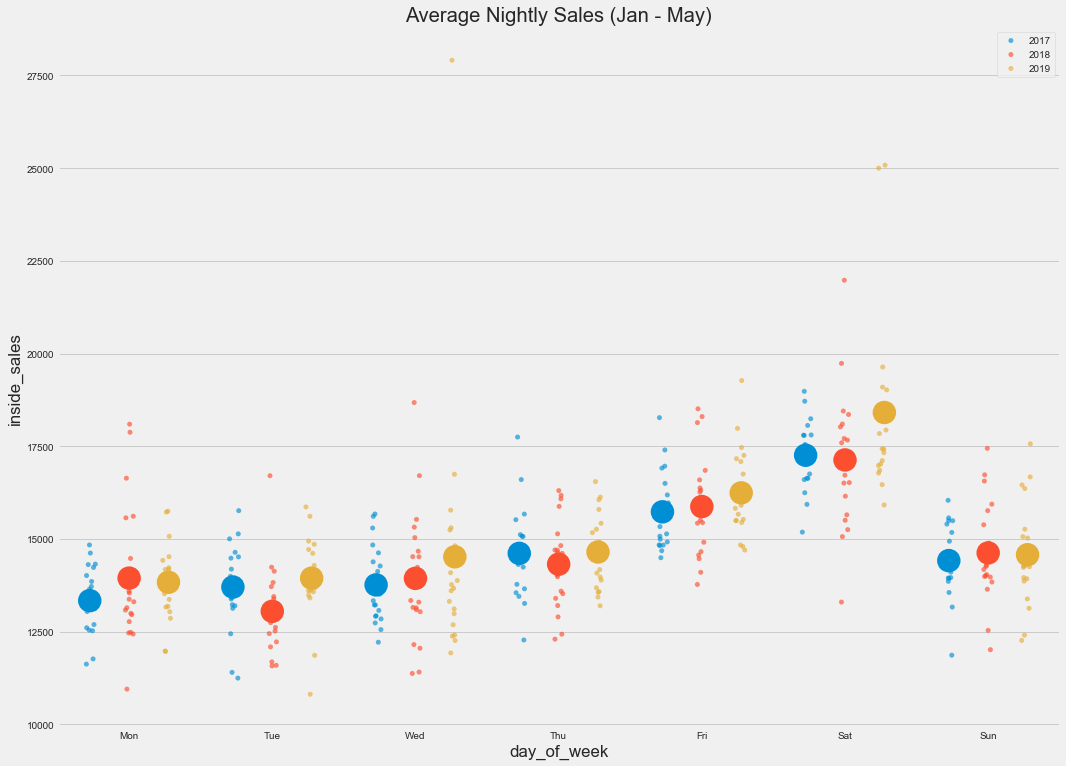

In [266]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,12))
sns.stripplot(x='day_of_week',
               y=target,
               hue='year',
               data=df_ytd,
               dodge=0.35,
               alpha=0.65
                );

sns.pointplot(x='day_of_week',
               y=target,
               hue='year',
               data=df_ytd,
               dodge=0.55,
               alpha=0.75,
               join=False,
               ci=None
                );


plt.legend(['2017', '2018', '2019'])
plt.title('Average Nightly Sales (Jan - May)');

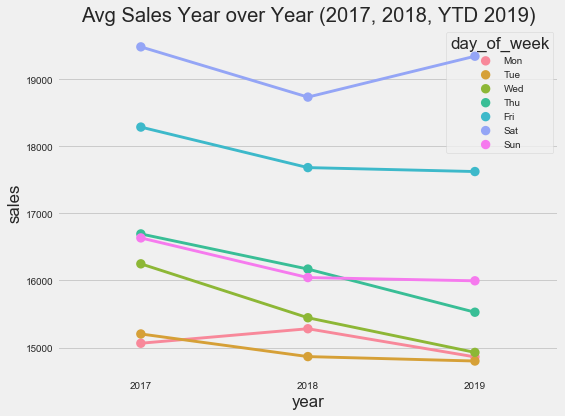

In [43]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8,6))

sns.pointplot(x='year',
               y='sales',
               hue='day_of_week',
               data=df,
               alpha=0.75,
               join=True,
               ci=False,
               scale=0.4
                )

plt.title('Avg Sales Year over Year (2017, 2018, YTD 2019)');